# Computer Vision

To work in this Colab notebook, first save a copy of it via "File" -> "Save a copy in Drive" in the top-left menu bar.


### 1. Install all missing packages that we need an download our custom FashionMNIST data

The data files will be available locally in your Colab runtime. You can find them through the files menu on the left.

In [ ]:
# Install packages
!pip install torchmetrics gdown

# Download training, validation, and test splits
!gdown https://drive.google.com/uc?id=1zYfBlExr_LK-Ld8rmxCTqRU5RAOUVVfh
!gdown https://drive.google.com/uc?id=1PJa_I3qG0P5whuARV_Se1_YUvHzR469R
!gdown https://drive.google.com/uc?id=1pC8-ummMGy1dPhHGPuNsms5_I7HpWgv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 27.0 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=1zYfBlExr_LK-Ld8rmxCTqRU5RAOUVVfh
To: /content/fashion_mnist_training.pt
100% 3.93M/3.93M [00:00<00:00, 240MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PJa_I3qG0P5whuARV_Se1_YUvHzR469R
To: /content/fashion_mnist_validation.pt
100% 786k/786k [00:00<00:00, 104MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pC8-ummMGy1dPhHGPuNsms5_I7HpWgv2
To: /content/fashion_mnist_test.pt
100% 786k/786k [00:00<00:00, 139MB/s]


### 2. Import classes and functions we will be using

In [ ]:
import math
import os
import random
from typing import Any, Callable, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import DataLoader
from torchvision.datasets import VisionDataset
from torchvision.transforms import Compose, Lambda, ToTensor, RandomVerticalFlip, RandomHorizontalFlip
from torchvision.models.resnet import ResNet, BasicBlock
from torchmetrics.functional.classification import multiclass_confusion_matrix

### 3. Check which PyTorch version we are running and confirm that we are in a GPU runtime.
If this output shows that you are not in a GPU runtime, go to "Runtime" in the top-left menu bar -> "Change runtime type" -> set "Hardware Accelerator: GPU".

In [ ]:
print(f"Running PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
!nvidia-smi

Running PyTorch version: 2.0.0+cu118
CUDA available: True
Tue Apr  4 11:12:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                              

### 4. Make things (more) reproducible by setting random seeds

See here for details: https://pytorch.org/docs/stable/notes/randomness.html

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### 5. Define our custom IDS FashionMNIST PyTorch dataset

Our model inherits, i.e. is a specific kind of, `VisionDataset` in torchvision.\
This means it has all features defined in `VisionDataset`, unless they are explicitly overridden here, \
plus any additional functionality that may be defined below. You can read more about `VisionDataset` here: https://pytorch.org/vision/main/generated/torchvision.datasets.VisionDataset.html. 

In [ ]:
class IDSFashionMnistDataset(VisionDataset):
    """
    FashionMNIST dataset for the IDS course which loads custom data files from disk
    """
    
    classes = [
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]
    
    def __init__(
        self,
        root: str,
        split: str = "training",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        
        if not split in ["training", "validation", "test"]:
            raise ValueError("Split should be 'training', 'validation', or 'test'.")
            
        self.split = split
        self.root = root
        
        self.data, self.targets = self._load_data()
    
    def _load_data(self):
        data = torch.load(os.path.join(self.root, f"fashion_mnist_{self.split}.pt"))
        images = data[:, :-1].reshape(-1, 28, 28)  # 28x28 resolution
        labels = data[:, -1]
        return images, labels 
    
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode="L")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target
    
    def __len__(self):
        return len(self.data)

### 6. Define our custom ResNet-18 model for FashionMNIST
The original ResNet-18 uses 3-channel (RGB) inputs and has 1000 output classes based on ImageNet-1K.

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

We instead use single-channel inputs (Grayscale) and 10 output classes according to FashionMNIST.

In [ ]:
class FashionMnistResNet18(ResNet):
    """
    Custom ResNet-18 model which uses 1 input channel (grayscale) and has 10 output classes
    """
    def __init__(self):
        super().__init__(BasicBlock, [2,2,2,2,2], num_classes=10)
        self.conv1 = nn.Conv2d(1, 64,
          kernel_size=(7, 7),
          stride=(2, 2),
          padding=(3, 3),
          bias=False
        )

In [ ]:
from torchvision.transforms import Compose

### 7. Load our custom FashionMNIST data

Here, we load our data using the `IDSFashionMnistDataset` class defined above. We also make use of the functionality in torchvision's `VisionDataset`, which `IDSFashionMnistDataset` inherits from, to set the transformations we want to apply when retrieving examples from our dataset. We use the `transform` keyword argument for this and compose our transformations using torchvision's `Compose` (https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html). In our base setting, the only transformation we apply is `ToTensor`, which converts our `PIL.Image` inputs into PyTorch tensors.

In [ ]:
# Create base transformation for our dataset
# TODO: how can these be modified to randomly flip examples?
base_transform_V = Compose([
     RandomVerticalFlip(p=0.5), ToTensor()
])

base_transform_H = Compose([
    RandomHorizontalFlip(p=0.33),
    ToTensor()
])

base_transform = Compose([
    ToTensor(),
])

# Load datasets
train_dataset = IDSFashionMnistDataset(".", "training", transform=base_transform)
validation_dataset = IDSFashionMnistDataset(".", "validation", transform=base_transform)
test_dataset = IDSFashionMnistDataset(".", "test", transform=base_transform)

train_dataset_H = IDSFashionMnistDataset(".", "training", transform=base_transform_H)
validation_dataset_H = IDSFashionMnistDataset(".", "validation", transform=base_transform_H)
test_dataset_H = IDSFashionMnistDataset(".", "test", transform=base_transform_H)

train_dataset_V = IDSFashionMnistDataset(".", "training", transform=base_transform_V)
validation_dataset_V = IDSFashionMnistDataset(".", "validation", transform=base_transform_V)
test_dataset_V = IDSFashionMnistDataset(".", "test", transform=base_transform_V)


# Check the sizes of our datasets
print(f"Training dataset length = {len(train_dataset)}")
print(f"Validation dataset length = {len(validation_dataset)}")
print(f"Test dataset length = {len(test_dataset)}")

Training dataset length = 5000
Validation dataset length = 1000
Test dataset length = 1000


### 8. Implement our evaluation function and training loop

Below, we provide some rudimentary functionality for training and evaluation,\
as well as metric storing and logging, for our experiments.

In [ ]:
def log_metrics(metrics: dict, step: Optional[int] = None):
    """
    Log metrics stored in a dictionary
    """

    # During training, it can be useful to also log the current step
    if step is not None:
        print(f"\nMetrics step {step}:")

    for k, v in metrics.items():
        # We ignore the confusion matrix when logging metrics
        if not k.endswith("conf_matrix"):
            print(f"  {k}: {v}")

def evaluate(model, eval_dataloader, prefix="eval"):
    """
    Evaluation function that computes the loss, accuracy, and confusion matrix for the dataset
    passed via the `eval_dataloader` argument
    """
    
    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Move model to GPU
    model.cuda()

    # Set model to evaluation mode (e.g. to disable dropout)
    model.eval()

    eval_loss = 0
    y_pred = None
    y_true = None
    num_classes = None
    
    for batch_idx, batch in enumerate(tqdm(eval_dataloader, desc=f"Evaluating")):
        # Loop over batches in dataloader
        
        # Move batch to GPU
        inputs, labels = batch
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        # Use no_grad mode to disable gradient computation
        with torch.no_grad():
            # Get model outputs
            outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        eval_loss += loss.detach().cpu().item()

        if num_classes is None:
            num_classes = len(outputs[0])
        
        # Get class predictions
        preds = torch.argmax(outputs, dim=-1)
        
        # Accumulate predictions and true classes over batches
        y_pred = torch.cat([y_pred, preds]) if y_pred is not None else preds
        y_true = torch.cat([y_true, labels]) if y_true is not None else labels

    
    # Move predictions and true classes back to CPU
    y_pred = y_pred.detach().cpu()
    y_true = y_true.detach().cpu()
  
    # Compute metrics
    eval_loss /= len(eval_dataloader)
    eval_acc = (y_pred == y_true).sum() / len(y_true)
    eval_conf_matrix = multiclass_confusion_matrix(
        y_pred, y_true, num_classes=num_classes
    )
    
    # Store metrics in a dictionary
    metrics = {
        f"{prefix}_loss": eval_loss,
        f"{prefix}_accuracy": eval_acc.item(),
        f"{prefix}_conf_matrix": eval_conf_matrix.numpy()
    }

    return metrics


def save_best_model(model: nn.Module):
  """
  Simple function that saves the weights of the specified model to disk.
  We use this to keep track of the best model (based on validation loss).
  """
  output_path = "best_model.pt"
  torch.save(model.state_dict(), output_path)
  print(f"Saved new best model to {output_path}\n")


def load_best_model(model: nn.Module, model_path: str = "best_model.pt"):
  """
  Simple function that loads model weights stored at `model_path` into the 
  passed model of type `nn.Module`. We use this to load our best model checkpoint.
  """
  model.load_state_dict(torch.load(model_path))
  model.eval()
  print(f"Loaded best {model.__class__.__name__} model from {model_path}\n")
  return model


def train(
  model: nn.Module,
  train_dataloader: DataLoader,
  eval_dataloader: DataLoader,
  num_epochs: int = 20,
  lr: float = 0.1,
  eval_steps: int = 100
):
    """
    Training loop
    """
    
    # Create SGD optimizer with specified learning rate and fixed momentum
    optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)
    
    # Create linear learning rate decay schedule
    scheduler = LinearLR(
        optimizer,
        start_factor=1.0,
        end_factor=1e-6,
        total_iters=len(train_dataloader) * num_epochs
    )
    
    # Define loss function
    criterion = nn.CrossEntropyLoss()
    
    # Move model to GPU
    model.cuda()

    total_loss = 0
    total_eval_loss = 0
    global_step = 0
    global_eval_step = 0
    best_eval_loss = float("inf")

    # Store our initial model
    save_best_model(model)

    # Create dictionary to store metrics throughout training
    metrics_dict = {}

    print("Starting model training")

    for epoch_idx in range(num_epochs):
        # Epoch loop (one epoch is one pass over the full training dataset)
        
        for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch_idx+1}")):
            # Loop over batches in training dataset
            
            # Set model to training mode
            model.train()

            global_step += 1
            
            # Move batch to GPU
            inputs, labels = batch
            inputs = inputs.cuda()
            labels = labels.cuda()
            
            # Get model outputs
            outputs = model(inputs)
            
            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.detach().cpu().item()
            
            # Evaluation loop
            if global_step % eval_steps == 0:
                global_eval_step += 1
                metrics = {
                    "mean_train_loss": total_loss / global_step,
                    "learning_rate": scheduler.get_last_lr()[0]
                }

                # Evaluate on validation and training datasets
                metrics.update(evaluate(model, eval_dataloader, prefix="eval"))
                metrics.update(evaluate(model, train_dataloader, prefix="train"))

                # Update and log metrics
                total_eval_loss += metrics["eval_loss"]
                metrics["mean_eval_loss"] = total_eval_loss / global_eval_step
                log_metrics(metrics, step=global_step)
                metrics_dict[global_step] = metrics
            
                # Check if our validation loss has decreased, and if so,
                # update our best model checkpoint
                if metrics["eval_loss"] <= best_eval_loss:
                  best_eval_loss = metrics["eval_loss"]
                  save_best_model(model)

            # Compute gradients
            loss.backward()
            
            # Perform update step
            optimizer.step()
            
            # Reduce learning rate for stability
            scheduler.step()
            
            # Set gradients to zero
            model.zero_grad()

    return metrics_dict

### 9. Define hyperparameters, create dataloaders, instantiate model, and run training/evaluation procedure

Here, we set our hyper-parameters for the dataloader (batch size) and the training loop \
(number of epochs, learning rate, and evaluation interval in steps).

We only use very basic data loading functionality. More information on available features can be found here https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader.

In [ ]:
# TODO: set your hyperparameters
bs = 256
num_epochs = 100
lr = 0.1
eval_steps = 100

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=bs, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

train_dataloader_H = DataLoader(train_dataset_H, batch_size=bs, shuffle=True)
validation_dataloader_H = DataLoader(validation_dataset_H, batch_size=bs, shuffle=False)
test_dataloader_H = DataLoader(test_dataset_H, batch_size=bs, shuffle=False)

train_dataloader_V = DataLoader(train_dataset_V, batch_size=bs, shuffle=True)
validation_dataloader_V = DataLoader(validation_dataset_V, batch_size=bs, shuffle=False)
test_dataloader_V = DataLoader(test_dataset_V, batch_size=bs, shuffle=False)
# Instantiate a new model
model = FashionMnistResNet18()

# Train model and save training and evaluation metrics
metrics_dict = train(
    model, train_dataloader, validation_dataloader, num_epochs=num_epochs, lr=lr, eval_steps=eval_steps
)

metrics_dict_H = train(
    model, train_dataloader_H, validation_dataloader_H, num_epochs=num_epochs, lr=lr, eval_steps=eval_steps
)

metrics_dict_V = train(
    model, train_dataloader_V, validation_dataloader_V, num_epochs=num_epochs, lr=lr, eval_steps=eval_steps
)


Saved new best model to best_model.pt

Starting model training


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 21.90it/s]

Epoch 5: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]



Metrics step 100:
  mean_train_loss: 0.842326907813549
  learning_rate: 0.09505000494999999
  eval_loss: 0.5414284244179726
  eval_accuracy: 0.7900000214576721
  train_loss: 0.47104342132806776
  train_accuracy: 0.8191999793052673
  mean_eval_loss: 0.5414284244179726
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 23.64it/s]

Epoch 10: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]



Metrics step 200:
  mean_train_loss: 0.5871497262269258
  learning_rate: 0.09005000994999993
  eval_loss: 0.4561493322253227
  eval_accuracy: 0.8399999737739563
  train_loss: 0.23487783670425416
  train_accuracy: 0.9172000288963318
  mean_eval_loss: 0.49878887832164764
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 24.50it/s]

Epoch 15: 100%|██████████| 20/20 [00:01<00:00, 10.41it/s]



Metrics step 300:
  mean_train_loss: 0.45689130504926045
  learning_rate: 0.08505001494999989
  eval_loss: 0.5283315181732178
  eval_accuracy: 0.8379999995231628
  train_loss: 0.1467272501438856
  train_accuracy: 0.9458000063896179
  mean_eval_loss: 0.5086364249388377


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 14.77it/s]

Epoch 20: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]



Metrics step 400:
  mean_train_loss: 0.36904584934003654
  learning_rate: 0.08005001994999977
  eval_loss: 0.674459382891655
  eval_accuracy: 0.8420000076293945
  train_loss: 0.10921698547899723
  train_accuracy: 0.9595999717712402
  mean_eval_loss: 0.550092164427042


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 25.46it/s]

Epoch 25: 100%|██████████| 20/20 [00:01<00:00, 10.78it/s]



Metrics step 500:
  mean_train_loss: 0.3101316544190049
  learning_rate: 0.07505002494999956
  eval_loss: 0.6734988391399384
  eval_accuracy: 0.847000002861023
  train_loss: 0.04820467345416546
  train_accuracy: 0.9833999872207642
  mean_eval_loss: 0.5747734993696213


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 16.85it/s]

Epoch 30: 100%|██████████| 20/20 [00:02<00:00,  7.09it/s]



Metrics step 600:
  mean_train_loss: 0.2644468198204413
  learning_rate: 0.07005002994999944
  eval_loss: 0.7608092874288559
  eval_accuracy: 0.8610000014305115
  train_loss: 0.04242857564240694
  train_accuracy: 0.98580002784729
  mean_eval_loss: 0.6057794640461603


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 23.55it/s]

Epoch 35: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s]



Metrics step 700:
  mean_train_loss: 0.2283290598766845
  learning_rate: 0.06505003494999935
  eval_loss: 0.9136343747377396
  eval_accuracy: 0.8550000190734863
  train_loss: 0.006661350361537188
  train_accuracy: 0.9973999857902527
  mean_eval_loss: 0.6497587370021003


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.93it/s]

Epoch 40: 100%|██████████| 20/20 [00:02<00:00,  8.06it/s]



Metrics step 800:
  mean_train_loss: 0.20007203182138256
  learning_rate: 0.06005003994999934
  eval_loss: 0.9600431472063065
  eval_accuracy: 0.8629999756813049
  train_loss: 0.0002095081810693955
  train_accuracy: 1.0
  mean_eval_loss: 0.688544288277626


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 25.21it/s]

Epoch 45: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s]



Metrics step 900:
  mean_train_loss: 0.17788198698822977
  learning_rate: 0.055050044949999356
  eval_loss: 0.9818057864904404
  eval_accuracy: 0.8600000143051147
  train_loss: 0.0001009304307444836
  train_accuracy: 1.0
  mean_eval_loss: 0.721128899190161


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 25.75it/s]

Epoch 50: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]



Metrics step 1000:
  mean_train_loss: 0.16011077778684193
  learning_rate: 0.050050049949999446
  eval_loss: 1.0026489794254303
  eval_accuracy: 0.8600000143051147
  train_loss: 6.886938681418541e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.7492809072136879


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 24.43it/s]

Epoch 55: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s]



Metrics step 1100:
  mean_train_loss: 0.14556636214137886
  learning_rate: 0.045050054949999536
  eval_loss: 1.016273409128189
  eval_accuracy: 0.8579999804496765
  train_loss: 5.447855592137785e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.7735529528422789


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 24.07it/s]

Epoch 60: 100%|██████████| 20/20 [00:01<00:00, 10.44it/s]



Metrics step 1200:
  mean_train_loss: 0.13345520170851766
  learning_rate: 0.04005005994999966
  eval_loss: 0.953270211815834
  eval_accuracy: 0.8579999804496765
  train_loss: 0.00016224689279624726
  train_accuracy: 1.0
  mean_eval_loss: 0.7885293910900751


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 24.81it/s]

Epoch 65: 100%|██████████| 20/20 [00:01<00:00, 10.36it/s]



Metrics step 1300:
  mean_train_loss: 0.12320635371521908
  learning_rate: 0.03505006494999977
  eval_loss: 0.9389262646436691
  eval_accuracy: 0.8650000095367432
  train_loss: 7.747484050923958e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8000983813634286


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 23.40it/s]

Epoch 70: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]



Metrics step 1400:
  mean_train_loss: 0.1144152718010004
  learning_rate: 0.030050069949999845
  eval_loss: 0.9572390913963318
  eval_accuracy: 0.8610000014305115
  train_loss: 5.858476142748259e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8113227177943502


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 23.83it/s]

Epoch 75: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s]



Metrics step 1500:
  mean_train_loss: 0.10679564954925203
  learning_rate: 0.025050074949999862
  eval_loss: 0.9720157980918884
  eval_accuracy: 0.8610000014305115
  train_loss: 5.1435605928418224e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8220355898141861


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 25.16it/s]

Epoch 80: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s]



Metrics step 1600:
  mean_train_loss: 0.10012681377114858
  learning_rate: 0.02005007994999987
  eval_loss: 0.9829556345939636
  eval_accuracy: 0.8610000014305115
  train_loss: 4.720006627394469e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8320930926129222


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 24.26it/s]

Epoch 85: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s]



Metrics step 1700:
  mean_train_loss: 0.09424255304171525
  learning_rate: 0.015050084949999864
  eval_loss: 0.9868001788854599
  eval_accuracy: 0.8610000014305115
  train_loss: 4.2357021538919073e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8411935094524833


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 23.40it/s]

Epoch 90: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s]



Metrics step 1800:
  mean_train_loss: 0.08901211962980293
  learning_rate: 0.010050089949999917
  eval_loss: 0.9942409247159958
  eval_accuracy: 0.8600000143051147
  train_loss: 3.964278512285091e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8496961436337895


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 24.37it/s]

Epoch 95: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s]



Metrics step 1900:
  mean_train_loss: 0.08433267324343481
  learning_rate: 0.005050094949999962
  eval_loss: 0.9907541424036026
  eval_accuracy: 0.8610000014305115
  train_loss: 4.015472877654247e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8571202488322007


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 25.22it/s]

Epoch 100: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s]



Metrics step 2000:
  mean_train_loss: 0.08012037969331323
  learning_rate: 5.009994999999962e-05
  eval_loss: 1.0057965368032455
  eval_accuracy: 0.8600000143051147
  train_loss: 3.7431747114169414e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8645540632307529
Saved new best model to best_model.pt

Starting model training


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.51it/s]

Epoch 5: 100%|██████████| 20/20 [00:02<00:00,  7.96it/s]



Metrics step 100:
  mean_train_loss: 0.2741668676584959
  learning_rate: 0.09505000494999999
  eval_loss: 0.5372214019298553
  eval_accuracy: 0.8450000286102295
  train_loss: 0.1326628565788269
  train_accuracy: 0.9502000212669373
  mean_eval_loss: 0.5372214019298553
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 20.13it/s]

Epoch 10: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]



Metrics step 200:
  mean_train_loss: 0.19412985663861038
  learning_rate: 0.09005000994999993
  eval_loss: 0.5404084026813507
  eval_accuracy: 0.8700000047683716
  train_loss: 0.0737916965968907
  train_accuracy: 0.9751999974250793
  mean_eval_loss: 0.538814902305603


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.72it/s]

Epoch 15: 100%|██████████| 20/20 [00:02<00:00,  8.06it/s]



Metrics step 300:
  mean_train_loss: 0.15237067974482973
  learning_rate: 0.08505001494999989
  eval_loss: 0.7272641956806183
  eval_accuracy: 0.8489999771118164
  train_loss: 0.0432148851454258
  train_accuracy: 0.9846000075340271
  mean_eval_loss: 0.6016313334306082


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 13.82it/s]

Epoch 20: 100%|██████████| 20/20 [00:03<00:00,  6.39it/s]



Metrics step 400:
  mean_train_loss: 0.12628005869570189
  learning_rate: 0.08005001994999977
  eval_loss: 0.8207844346761703
  eval_accuracy: 0.8489999771118164
  train_loss: 0.05853699035942554
  train_accuracy: 0.979200005531311
  mean_eval_loss: 0.6564196087419987


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.68it/s]

Epoch 25: 100%|██████████| 20/20 [00:02<00:00,  8.07it/s]



Metrics step 500:
  mean_train_loss: 0.10847628345433623
  learning_rate: 0.07505002494999956
  eval_loss: 0.7051431685686111
  eval_accuracy: 0.8579999804496765
  train_loss: 0.013706139498390257
  train_accuracy: 0.9962000250816345
  mean_eval_loss: 0.6661643207073211


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.94it/s]

Epoch 30: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]



Metrics step 600:
  mean_train_loss: 0.09305166431896698
  learning_rate: 0.07005002994999944
  eval_loss: 0.8205312937498093
  eval_accuracy: 0.8619999885559082
  train_loss: 0.010682113619986921
  train_accuracy: 0.9965999722480774
  mean_eval_loss: 0.6918921495477358


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.39it/s]

Epoch 35: 100%|██████████| 20/20 [00:02<00:00,  6.76it/s]



Metrics step 700:
  mean_train_loss: 0.08078160592749814
  learning_rate: 0.06505003494999935
  eval_loss: 0.9225676357746124
  eval_accuracy: 0.8619999885559082
  train_loss: 0.004802494071191177
  train_accuracy: 0.9983999729156494
  mean_eval_loss: 0.7248457904372897


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.72it/s]

Epoch 40: 100%|██████████| 20/20 [00:02<00:00,  8.10it/s]



Metrics step 800:
  mean_train_loss: 0.07105711304517172
  learning_rate: 0.06005003994999934
  eval_loss: 1.0046937465667725
  eval_accuracy: 0.8560000061988831
  train_loss: 0.0008266338205430657
  train_accuracy: 1.0
  mean_eval_loss: 0.759826784953475


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 13.16it/s]

Epoch 45: 100%|██████████| 20/20 [00:02<00:00,  6.71it/s]



Metrics step 900:
  mean_train_loss: 0.0633658575122859
  learning_rate: 0.055050044949999356
  eval_loss: 0.9847127795219421
  eval_accuracy: 0.8579999804496765
  train_loss: 0.0007016070907411631
  train_accuracy: 1.0
  mean_eval_loss: 0.7848141176833047


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.57it/s]

Epoch 50: 100%|██████████| 20/20 [00:02<00:00,  8.09it/s]



Metrics step 1000:
  mean_train_loss: 0.057131083656844564
  learning_rate: 0.050050049949999446
  eval_loss: 0.9716626554727554
  eval_accuracy: 0.8560000061988831
  train_loss: 0.00038979801902314646
  train_accuracy: 1.0
  mean_eval_loss: 0.8034989714622498


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.21it/s]

Epoch 55: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]



Metrics step 1100:
  mean_train_loss: 0.051993408012395693
  learning_rate: 0.045050054949999536
  eval_loss: 1.0047237873077393
  eval_accuracy: 0.8519999980926514
  train_loss: 0.00022479519011540106
  train_accuracy: 1.0
  mean_eval_loss: 0.8217921365391124


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 19.57it/s]

Epoch 60: 100%|██████████| 20/20 [00:02<00:00,  8.00it/s]



Metrics step 1200:
  mean_train_loss: 0.04769978662917007
  learning_rate: 0.04005005994999966
  eval_loss: 1.0576827377080917
  eval_accuracy: 0.8519999980926514
  train_loss: 0.00011668202587316046
  train_accuracy: 1.0
  mean_eval_loss: 0.8414496866365274


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.20it/s]

Epoch 65: 100%|██████████| 20/20 [00:02<00:00,  7.83it/s]



Metrics step 1300:
  mean_train_loss: 0.044048207699236695
  learning_rate: 0.03505006494999977
  eval_loss: 1.0448308736085892
  eval_accuracy: 0.8569999933242798
  train_loss: 9.740441983012716e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.857094393326686


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 13.25it/s]

Epoch 70: 100%|██████████| 20/20 [00:03<00:00,  6.41it/s]



Metrics step 1400:
  mean_train_loss: 0.04091396431290247
  learning_rate: 0.030050069949999845
  eval_loss: 1.071514442563057
  eval_accuracy: 0.8479999899864197
  train_loss: 6.74104638164863e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8724101111292839


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 19.26it/s]

Epoch 75: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]



Metrics step 1500:
  mean_train_loss: 0.038202346517848734
  learning_rate: 0.025050074949999862
  eval_loss: 1.0593384951353073
  eval_accuracy: 0.8569999933242798
  train_loss: 7.219678154797293e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8848720033963521


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.94it/s]

Epoch 80: 100%|██████████| 20/20 [00:02<00:00,  7.86it/s]



Metrics step 1600:
  mean_train_loss: 0.03582512590771898
  learning_rate: 0.02005007994999987
  eval_loss: 1.089679703116417
  eval_accuracy: 0.8529999852180481
  train_loss: 5.92130630138854e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8976724846288562


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 20.24it/s]

Epoch 85: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]



Metrics step 1700:
  mean_train_loss: 0.0337260623393933
  learning_rate: 0.015050084949999864
  eval_loss: 1.03562992811203
  eval_accuracy: 0.8539999723434448
  train_loss: 5.6745483288977996e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.9057876283631605


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 20.38it/s]

Epoch 90: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]



Metrics step 1800:
  mean_train_loss: 0.031859845746423365
  learning_rate: 0.010050089949999917
  eval_loss: 1.0491801798343658
  eval_accuracy: 0.8569999933242798
  train_loss: 4.900198846371495e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.913753881222672


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 14.49it/s]

Epoch 95: 100%|██████████| 20/20 [00:03<00:00,  6.47it/s]



Metrics step 1900:
  mean_train_loss: 0.03018889108387061
  learning_rate: 0.005050094949999962
  eval_loss: 1.0389006286859512
  eval_accuracy: 0.8550000190734863
  train_loss: 6.568678873009048e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.9203405521417919


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.92it/s]

Epoch 100: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]



Metrics step 2000:
  mean_train_loss: 0.02868581410488514
  learning_rate: 5.009994999999962e-05
  eval_loss: 1.053241804242134
  eval_accuracy: 0.8619999885559082
  train_loss: 5.259677627691417e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.926985614746809
Saved new best model to best_model.pt

Starting model training


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 19.77it/s]

Epoch 5: 100%|██████████| 20/20 [00:02<00:00,  7.42it/s]



Metrics step 100:
  mean_train_loss: 0.4833946281671524
  learning_rate: 0.09505000494999999
  eval_loss: 0.4702167436480522
  eval_accuracy: 0.843999981880188
  train_loss: 0.22104045674204825
  train_accuracy: 0.9228000044822693
  mean_eval_loss: 0.4702167436480522
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 19.52it/s]

Epoch 10: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]



Metrics step 200:
  mean_train_loss: 0.3381807067245245
  learning_rate: 0.09005000994999993
  eval_loss: 0.585564486682415
  eval_accuracy: 0.8320000171661377
  train_loss: 0.16493838988244533
  train_accuracy: 0.9398000240325928
  mean_eval_loss: 0.5278906151652336


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.65it/s]

Epoch 15: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]



Metrics step 300:
  mean_train_loss: 0.2658318056166172
  learning_rate: 0.08505001494999989
  eval_loss: 0.6782510876655579
  eval_accuracy: 0.8299999833106995
  train_loss: 0.12585846856236457
  train_accuracy: 0.9563999772071838
  mean_eval_loss: 0.5780107726653417


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.44it/s]

Epoch 20: 100%|██████████| 20/20 [00:02<00:00,  7.37it/s]



Metrics step 400:
  mean_train_loss: 0.2187925414275378
  learning_rate: 0.08005001994999977
  eval_loss: 0.7597202658653259
  eval_accuracy: 0.8420000076293945
  train_loss: 0.06280313022434711
  train_accuracy: 0.9782000184059143
  mean_eval_loss: 0.6234381459653378


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.49it/s]

Epoch 25: 100%|██████████| 20/20 [00:02<00:00,  8.23it/s]



Metrics step 500:
  mean_train_loss: 0.18521266271360218
  learning_rate: 0.07505002494999956
  eval_loss: 0.7781338095664978
  eval_accuracy: 0.8320000171661377
  train_loss: 0.05820963736623526
  train_accuracy: 0.9800000190734863
  mean_eval_loss: 0.6543772786855697


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.40it/s]

Epoch 30: 100%|██████████| 20/20 [00:02<00:00,  6.85it/s]



Metrics step 600:
  mean_train_loss: 0.15986942611945174
  learning_rate: 0.07005002994999944
  eval_loss: 0.9260710179805756
  eval_accuracy: 0.8460000157356262
  train_loss: 0.020550593663938344
  train_accuracy: 0.9929999709129333
  mean_eval_loss: 0.6996595685680708


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.96it/s]

Epoch 35: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]



Metrics step 700:
  mean_train_loss: 0.1387898869287788
  learning_rate: 0.06505003494999935
  eval_loss: 0.9961327165365219
  eval_accuracy: 0.8399999737739563
  train_loss: 0.009309822146315127
  train_accuracy: 0.996999979019165
  mean_eval_loss: 0.7420128754207066


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 19.16it/s]

Epoch 40: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]



Metrics step 800:
  mean_train_loss: 0.12279314348510524
  learning_rate: 0.06005003994999934
  eval_loss: 0.9704262316226959
  eval_accuracy: 0.8550000190734863
  train_loss: 0.010030524735338987
  train_accuracy: 0.9973999857902527
  mean_eval_loss: 0.7705645449459553


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 19.76it/s]

Epoch 45: 100%|██████████| 20/20 [00:02<00:00,  7.80it/s]



Metrics step 900:
  mean_train_loss: 0.1098731806533437
  learning_rate: 0.055050044949999356
  eval_loss: 0.9847196340560913
  eval_accuracy: 0.8529999852180481
  train_loss: 0.015786550764460117
  train_accuracy: 0.9945999979972839
  mean_eval_loss: 0.7943595548470815


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 19.61it/s]

Epoch 50: 100%|██████████| 20/20 [00:02<00:00,  8.23it/s]



Metrics step 1000:
  mean_train_loss: 0.09958297603111714
  learning_rate: 0.050050049949999446
  eval_loss: 0.9532255679368973
  eval_accuracy: 0.8569999933242798
  train_loss: 0.0016952499383478426
  train_accuracy: 0.9994000196456909
  mean_eval_loss: 0.8102461561560631


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 13.41it/s]

Epoch 55: 100%|██████████| 20/20 [00:03<00:00,  6.37it/s]



Metrics step 1100:
  mean_train_loss: 0.09066212472802197
  learning_rate: 0.045050054949999536
  eval_loss: 0.9964320510625839
  eval_accuracy: 0.8429999947547913
  train_loss: 0.00035500308440532534
  train_accuracy: 1.0
  mean_eval_loss: 0.8271721466021105


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.92it/s]

Epoch 60: 100%|██████████| 20/20 [00:02<00:00,  8.18it/s]



Metrics step 1200:
  mean_train_loss: 0.08314866057578305
  learning_rate: 0.04005005994999966
  eval_loss: 0.9798228740692139
  eval_accuracy: 0.8550000190734863
  train_loss: 0.00020163437475275713
  train_accuracy: 1.0
  mean_eval_loss: 0.8398930405577024


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 19.63it/s]

Epoch 65: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]



Metrics step 1300:
  mean_train_loss: 0.07677762059682909
  learning_rate: 0.03505006494999977
  eval_loss: 1.0386887043714523
  eval_accuracy: 0.8500000238418579
  train_loss: 0.00014039989036973566
  train_accuracy: 1.0
  mean_eval_loss: 0.8551850146972216


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 19.59it/s]

Epoch 70: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]



Metrics step 1400:
  mean_train_loss: 0.07132103998110584
  learning_rate: 0.030050069949999845
  eval_loss: 1.0503972321748734
  eval_accuracy: 0.8529999852180481
  train_loss: 0.0001261177378182765
  train_accuracy: 1.0
  mean_eval_loss: 0.8691287445170539


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.83it/s]

Epoch 75: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]



Metrics step 1500:
  mean_train_loss: 0.06658231167246897
  learning_rate: 0.025050074949999862
  eval_loss: 1.0899312645196915
  eval_accuracy: 0.8500000238418579
  train_loss: 9.423681203770684e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8838489125172297


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 13.91it/s]

Epoch 80: 100%|██████████| 20/20 [00:03<00:00,  6.46it/s]



Metrics step 1600:
  mean_train_loss: 0.062435871107088585
  learning_rate: 0.02005007994999987
  eval_loss: 1.0432142913341522
  eval_accuracy: 0.8579999804496765
  train_loss: 0.00010692996002035216
  train_accuracy: 1.0
  mean_eval_loss: 0.8938092486932874


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 19.45it/s]

Epoch 85: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]



Metrics step 1700:
  mean_train_loss: 0.05877341744773302
  learning_rate: 0.015050084949999864
  eval_loss: 1.062352642416954
  eval_accuracy: 0.8640000224113464
  train_loss: 0.0001000924577965634
  train_accuracy: 1.0
  mean_eval_loss: 0.9037235659711501


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.53it/s]

Epoch 90: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]



Metrics step 1800:
  mean_train_loss: 0.05551777346386087
  learning_rate: 0.010050089949999917
  eval_loss: 1.0621169060468674
  eval_accuracy: 0.8539999723434448
  train_loss: 9.088557508221128e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.9125231959753566


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 19.25it/s]

Epoch 95: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]



Metrics step 1900:
  mean_train_loss: 0.052604551622938936
  learning_rate: 0.005050094949999962
  eval_loss: 1.0298142284154892
  eval_accuracy: 0.8560000061988831
  train_loss: 7.99670146079734e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.9186964082090479


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.97it/s]

Epoch 100: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Metrics step 2000:
  mean_train_loss: 0.049983793968605826
  learning_rate: 5.009994999999962e-05
  eval_loss: 0.9968455284833908
  eval_accuracy: 0.8659999966621399
  train_loss: 8.50287617140566e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.922603864222765


### 10. Load our saved best model checkpoint
 
We can make use of the `load_best_model` function defined above to quickly load \
the best model checkpoint for further evaluation.

You can find more information on saving and loading model weights at

https://pytorch.org/tutorials/beginner/saving_loading_models.html.

In [ ]:
best_model = load_best_model(FashionMnistResNet18())

Loaded best FashionMnistResNet18 model from best_model.pt



### 11. Evaluate your best model and visualize the confusion matrix

TODO: You should implement this yourself using the functions defined above.

In [ ]:
# TODO
e = evaluate(best_model,test_dataloader)
e_H = evaluate(best_model,test_dataloader_H)
e_V = evaluate(best_model,test_dataloader_V)

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 15.70it/s]


In [ ]:
e['eval_conf_matrix']

array([[ 77,   0,   1,   7,   1,   1,   8,   0,   0,   0],
       [  0,  96,   1,   5,   1,   0,   1,   0,   1,   0],
       [  1,   0,  89,   0,   6,   0,   7,   0,   0,   0],
       [  3,   6,   2,  76,   5,   0,   4,   0,   0,   0],
       [  2,   0,  10,   2,  59,   0,  15,   0,   0,   0],
       [  0,   0,   0,   0,   0, 107,   0,   3,   0,   1],
       [ 17,   0,   8,   4,   6,   0,  62,   0,   2,   0],
       [  0,   0,   0,   0,   0,   0,   0,  90,   0,   8],
       [  1,   0,   0,   0,   0,   2,   2,   1, 104,   0],
       [  0,   0,   0,   0,   0,   0,   0,   5,   0,  90]])

In [ ]:
e_H['eval_conf_matrix']

array([[ 74,   0,   1,   8,   1,   1,  10,   0,   0,   0],
       [  0,  96,   1,   5,   1,   0,   1,   0,   1,   0],
       [  2,   0,  88,   0,   6,   0,   7,   0,   0,   0],
       [  3,   8,   4,  72,   5,   0,   4,   0,   0,   0],
       [  1,   0,  12,   2,  60,   0,  13,   0,   0,   0],
       [  0,   0,   2,   0,   0,  99,   0,   2,   7,   1],
       [ 15,   0,   7,   4,   7,   0,  64,   0,   2,   0],
       [  0,   0,   0,   0,   0,   8,   0,  60,  24,   6],
       [  2,   0,   0,   0,   0,   1,   2,   1, 104,   0],
       [  2,   0,   0,   0,   0,   0,   0,   5,  28,  60]])

In [ ]:
e_V['eval_conf_matrix']

array([[ 81,   0,   1,   6,   1,   1,   5,   0,   0,   0],
       [  0,  97,   1,   4,   1,   0,   1,   0,   1,   0],
       [  0,   0,  88,   0,  10,   0,   5,   0,   0,   0],
       [  2,   5,   2,  76,   7,   0,   3,   0,   1,   0],
       [  2,   0,  14,   3,  60,   0,   9,   0,   0,   0],
       [  0,   0,   0,   0,   0, 105,   0,   5,   0,   1],
       [ 20,   0,  13,   2,   9,   0,  53,   0,   2,   0],
       [  0,   0,   0,   0,   0,   2,   0,  90,   0,   6],
       [  0,   0,   0,   0,   0,   2,   2,   0, 106,   0],
       [  0,   0,   0,   0,   0,   0,   0,   5,   0,  90]])

### 12. Plot your loss curves

TODO: You should implement this yourself. Use the `metrics_dict` returned by the training loop.

In [ ]:
# TODO
loss_list =[]
metrics_dict
for num in metrics_dict.keys():
#   print(num, metrics_dict[num]['mean_train_loss'],metrics_dict[num]['mean_eval_loss'])
   loss_list.append((num, metrics_dict[num]['mean_train_loss'],metrics_dict[num]['mean_eval_loss']))
df1 = pd.DataFrame(loss_list, columns =['number','mean_train_loss','mean_eval_loss'])
#sns.lineplot(data=df1, x= df1["number"], y=df1['mean_train_loss'])

In [ ]:
loss_list =[]
metrics_dict_H
for num in metrics_dict_H.keys():
#   print(num, metrics_dict[num]['mean_train_loss'],metrics_dict[num]['mean_eval_loss'])
   loss_list.append((num, metrics_dict_H[num]['mean_train_loss'],metrics_dict_H[num]['mean_eval_loss']))
df_H = pd.DataFrame(loss_list, columns =['number','H_flip_mean_train_loss','H_flip_mean_eval_loss'])
#sns.lineplot(data=df1, x= df1["number"], y=df1['mean_train_loss'])

In [ ]:
loss_list =[]
metrics_dict_V
for num in metrics_dict_V.keys():
#   print(num, metrics_dict[num]['mean_train_loss'],metrics_dict[num]['mean_eval_loss'])
   loss_list.append((num, metrics_dict_V[num]['mean_train_loss'],metrics_dict_V[num]['mean_eval_loss']))
df_V = pd.DataFrame(loss_list, columns =['number','V_flip_mean_train_loss','V_flip_mean_eval_loss'])
#sns.lineplot(data=df1, x= df1["number"], y=df1['mean_train_loss'])

In [ ]:
df_join = pd.merge(df1, df_H, how='inner', on = 'number')


In [ ]:
df_all = pd.merge(df_join, df_V, how='inner', on = 'number')
df_all

,number,mean_train_loss,mean_eval_loss,H_flip_mean_train_loss,H_flip_mean_eval_loss,V_flip_mean_train_loss,V_flip_mean_eval_loss
0,100,0.842327,0.541428,0.274167,0.537221,0.483395,0.470217
1,200,0.587150,0.498789,0.194130,0.538815,0.338181,0.527891
2,300,0.456891,0.508636,0.152371,0.601631,0.265832,0.578011
3,400,0.369046,0.550092,0.126280,0.656420,0.218793,0.623438
4,500,0.310132,0.574773,0.108476,0.666164,0.185213,0.654377
5,600,0.264447,0.605779,0.093052,0.691892,0.159869,0.699660
6,700,0.228329,0.649759,0.080782,0.724846,0.138790,0.742013
7,800,0.200072,0.688544,0.071057,0.759827,0.122793,0.770565
8,900,0.177882,0.721129,0.063366,0.784814,0.109873,0.794360
9,1000,0.160111,0.749281,0.057131,0.803499,0.099583,0.810246


Text(0.5, 1.0, 'mean_train_loss')

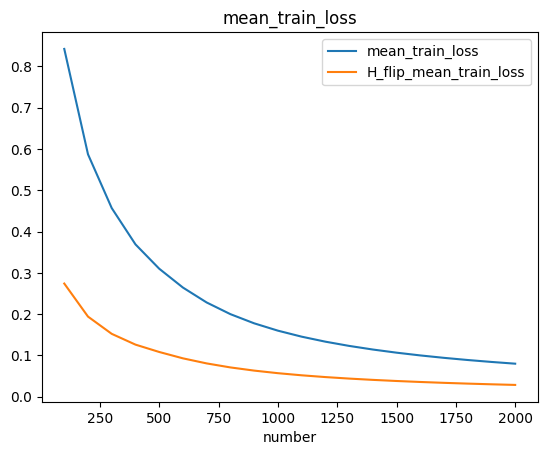

In [ ]:
df_all.plot(x="number",y = ['mean_train_loss','H_flip_mean_train_loss'])
plt.title("mean_train_loss")

#plt.subplot(1, 2, 2) # index 2
#sns.lineplot(data=df1, x= df1["number"], y=df1['mean_eval_loss'],color = "blue")
#plt.title("mean_eval_loss")


Text(0.5, 1.0, 'mean_eval_loss')

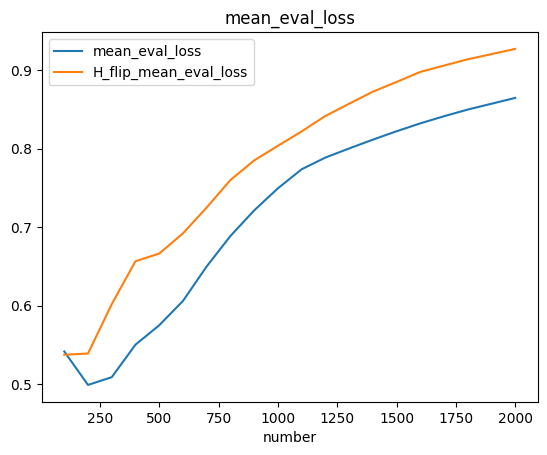

In [ ]:
df_all.plot(x="number",y = ['mean_eval_loss','H_flip_mean_eval_loss'])
plt.title("mean_eval_loss")


Text(0.5, 1.0, 'mean_train_loss')

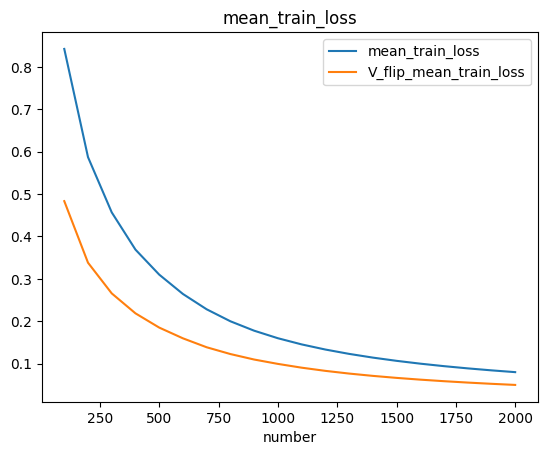

In [ ]:
#plot for Vertical Flip
df_all.plot(x="number",y = ['mean_train_loss','V_flip_mean_train_loss'])
plt.title("mean_train_loss")


Text(0.5, 1.0, 'mean_eval_loss')

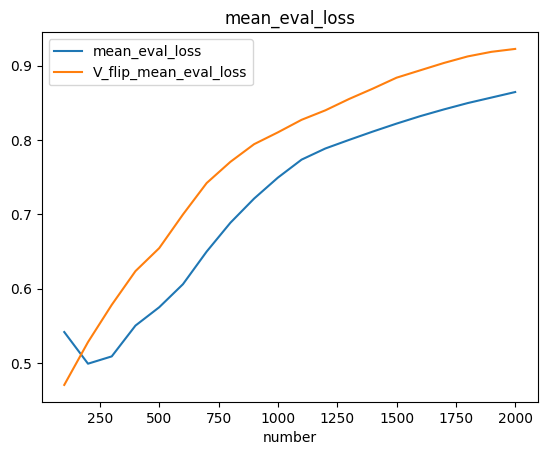

In [ ]:
df_all.plot(x="number",y = ['mean_eval_loss','V_flip_mean_eval_loss'])
plt.title("mean_eval_loss")

### 12. Plot your accuracy curves

TODO: You should implement this yourself. Use the `metrics_dict` returned by the training loop.

In [ ]:
# TODO
acc_list =[]
metrics_dict
for num in metrics_dict.keys():
    acc_list.append((num, metrics_dict[num]['eval_accuracy'],metrics_dict[num]['train_accuracy']))
dfa = pd.DataFrame(acc_list, columns =['number','eval_accuracy','train_accuracy'])

In [ ]:
acc_list =[]
metrics_dict_H
for num in metrics_dict_H.keys():
    acc_list.append((num, metrics_dict_H[num]['eval_accuracy'],metrics_dict_H[num]['train_accuracy']))
dfa_H = pd.DataFrame(acc_list, columns =['number','H_flip_eval_accuracy','H_flip_train_accuracy'])

In [ ]:
acc_list =[]
metrics_dict_V
for num in metrics_dict_V.keys():
    acc_list.append((num, metrics_dict_V[num]['eval_accuracy'],metrics_dict_V[num]['train_accuracy']))
dfa_V = pd.DataFrame(acc_list, columns =['number','V_flip_eval_accuracy','V_flip_train_accuracy'])

In [ ]:
dfa_join = pd.merge(dfa, dfa_H, how='inner', on = 'number')
dfa_all = pd.merge(dfa_join, dfa_V, how='inner', on = 'number')
dfa_all

,number,eval_accuracy,train_accuracy,H_flip_eval_accuracy,H_flip_train_accuracy,V_flip_eval_accuracy,V_flip_train_accuracy
0,100,0.790,0.8192,0.845,0.9502,0.844,0.9228
1,200,0.840,0.9172,0.870,0.9752,0.832,0.9398
2,300,0.838,0.9458,0.849,0.9846,0.830,0.9564
3,400,0.842,0.9596,0.849,0.9792,0.842,0.9782
4,500,0.847,0.9834,0.858,0.9962,0.832,0.9800
5,600,0.861,0.9858,0.862,0.9966,0.846,0.9930
6,700,0.855,0.9974,0.862,0.9984,0.840,0.9970
7,800,0.863,1.0000,0.856,1.0000,0.855,0.9974
8,900,0.860,1.0000,0.858,1.0000,0.853,0.9946
9,1000,0.860,1.0000,0.856,1.0000,0.857,0.9994


In [ ]:
metrics_dict

{100: {'mean_train_loss': 0.842326907813549,
  'learning_rate': 0.09505000494999999,
  'eval_loss': 0.5414284244179726,
  'eval_accuracy': 0.7900000214576721,
  'eval_conf_matrix': array([[ 72,   0,   5,   1,   0,   0,   7,   0,   1,   0],
         [  0, 101,   1,   2,   0,   1,   1,   0,   0,   0],
         [  2,   0,  98,   0,  11,   0,   2,   0,   1,   0],
         [ 10,   4,   1,  73,   7,   0,   0,   0,   0,   0],
         [  0,   0,  33,   4,  46,   0,   7,   1,   0,   0],
         [  0,   0,   0,   0,   0,  79,   0,   9,   1,   4],
         [ 19,   0,  35,   5,   7,   0,  25,   0,   2,   0],
         [  0,   0,   0,   0,   0,   2,   0,  85,   0,  13],
         [  1,   0,   1,   0,   1,   1,   4,   1, 102,   0],
         [  0,   0,   0,   0,   0,   1,   0,   1,   0, 109]]),
  'train_loss': 0.47104342132806776,
  'train_accuracy': 0.8191999793052673,
  'train_conf_matrix': array([[459,   0,  27,  10,   1,   1,  20,   0,   2,   0],
         [  0, 441,   5,   5,   2,   0,   1,   2, 

In [ ]:
metrics_dict[100]['eval_accuracy']

dict_keys([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000])

In [ ]:
metrics_dict[100]['eval_accuracy']

0.7900000214576721

Text(0.5, 1.0, 'Training accuracy')

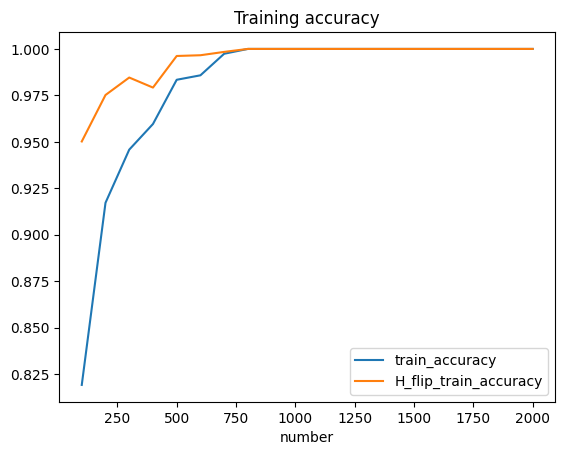

In [ ]:
dfa_all.plot(x="number",y = ['train_accuracy','H_flip_train_accuracy'])
plt.title("Training accuracy")

Text(0.5, 1.0, 'Eval accuracy')

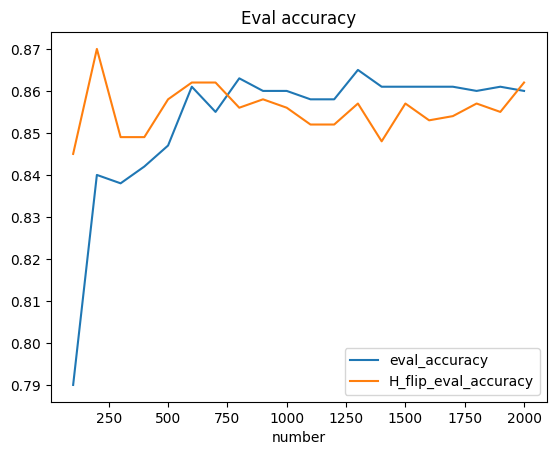

In [ ]:
dfa_all.plot(x="number",y = ['eval_accuracy','H_flip_eval_accuracy'])
plt.title("Eval accuracy")

Text(0.5, 1.0, 'Training accuracy')

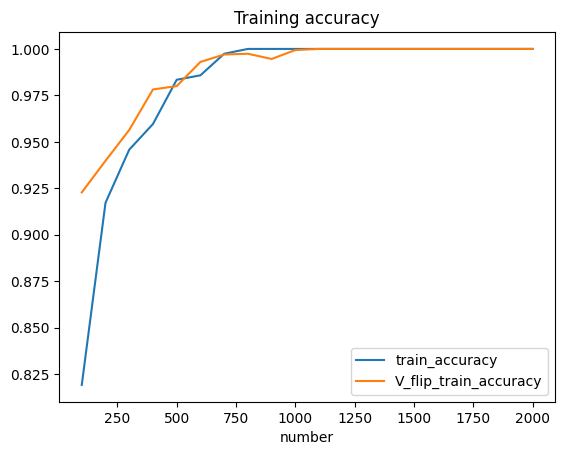

In [ ]:
dfa_all.plot(x="number",y = ['train_accuracy','V_flip_train_accuracy'])
plt.title("Training accuracy")

Text(0.5, 1.0, 'Eval accuracy')

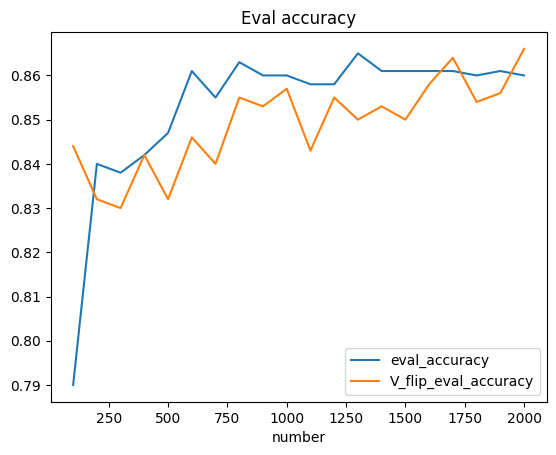

In [ ]:
dfa_all.plot(x="number",y = ['eval_accuracy','V_flip_eval_accuracy'])
plt.title("Eval accuracy")